In [4]:
%matplotlib inline
from numpy import *
import os
from os import listdir
from os.path import isfile, join
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from random import sample
from numpy import random

import tensorflow as tf

from caffe_classes import class_names

In [2]:
n_classes = 3 # my classes (1000 # ImageNet)
net_in = zeros((1, 227,227,3)).astype(float32)
net_out = zeros((1, n_classes))
xdim = net_in.shape[1:]
ydim = net_out.shape[1]
net_data = load("fine_tuned_net.npy").item()

In [3]:
# Read Image

im1 = (imread("poodle.png")[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)

In [6]:
def createOcclusion(im,roi_size,stride_size):     
    iters = floor((227-roi_size+1)/stride_size)
    iters = iters.astype(int)
    batch_size = iters**2
    batch = np.ndarray([batch_size,227, 227, 3])
    i = 0
    for r in range(0,iters):
        for c in range(0,iters):
            imOc = np.copy(im)
            imOc[r*stride_size:r*stride_size+roi_size-1,c*stride_size:c*stride_size+roi_size-1,:] = 0            
            batch[i] = imOc            
            i = i + 1
    return batch           

In [32]:
def softmax(w):
    w = np.array(w)
    maxes = np.amax(w, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(w-maxes) # The "max trick"
    dist = e / np.sum(e, axis=1)[:,None]
    return dist

In [5]:
# (self.feed('data')
#         .conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
#         .lrn(2, 2e-05, 0.75, name='norm1')
#         .max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
#         .conv(5, 5, 256, 1, 1, group=2, name='conv2')
#         .lrn(2, 2e-05, 0.75, name='norm2')
#         .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
#         .conv(3, 3, 384, 1, 1, name='conv3')
#         .conv(3, 3, 384, 1, 1, group=2, name='conv4')
#         .conv(3, 3, 256, 1, 1, group=2, name='conv5')
#         .fc(4096, name='fc6')
#         .fc(4096, name='fc7')
#         .fc(n_classes, relu=False, name='fc8')
#         .softmax(name='prob'))


def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    '''From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)   
    
    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups = tf.split(3, group, input)
        kernel_groups = tf.split(3, group, kernel)
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])


# Create model
def conv_net(x, weights, biases, dropout):
    
    #conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
    k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
    conv1_in = conv(x, weights['conv1W'], biases['conv1b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
    conv1 = tf.nn.relu(conv1_in)

    #lrn(2, 2e-05, 0.75, name='norm1')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn1 = tf.nn.local_response_normalization(conv1, depth_radius=radius, alpha=alpha, beta=beta, bias=bias)

    #max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)
    
    #conv(5, 5, 256, 1, 1, group=2, name='conv2')
    k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv2_in = conv(maxpool1, weights['conv2W'], biases['conv2b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv2 = tf.nn.relu(conv2_in)
    
    #lrn(2, 2e-05, 0.75, name='norm2')
    radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    lrn2 = tf.nn.local_response_normalization(conv2, depth_radius=radius, alpha=alpha, beta=beta, bias=bias)
    
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    #conv(3, 3, 384, 1, 1, name='conv3')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
    conv3_in = conv(maxpool2, weights['conv3W'], biases['conv3b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv3 = tf.nn.relu(conv3_in)
    
    #conv(3, 3, 384, 1, 1, group=2, name='conv4')
    k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
    conv4_in = conv(conv3, weights['conv4W'], biases['conv4b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv4 = tf.nn.relu(conv4_in)
    
    #conv(3, 3, 256, 1, 1, group=2, name='conv5')
    k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
    conv5_in = conv(conv4, weights['conv5W'], biases['conv5b'], k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv5 = tf.nn.relu(conv5_in)
    
    #max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
    k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
    maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)
    
    #fc(4096, name='fc6')
    fc6 = tf.nn.relu_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]), weights['fc6W'], biases['fc6B'])
    fc6 = tf.nn.dropout(fc6, dropout)
    
    #fc(4096, name='fc7')
    fc7 = tf.nn.relu_layer(fc6, weights['fc7W'], biases['fc7B'])
    fc7 = tf.nn.dropout(fc7, dropout)
    
    #fc(n_classes, relu=False, name='fc8')
    fc8 = tf.nn.xw_plus_b(fc7, weights['fc8W'], biases['fc8B'])
    
    return fc8

def getFeat(x):
    return prob(x,weights,biases)

In [6]:
# Store layers weight & bias
weights = {    
    'conv1W': tf.Variable(net_data["conv1"][0], name="c1w"),
    'conv2W': tf.Variable(net_data["conv2"][0], name="c2w"),
    'conv3W': tf.Variable(net_data["conv3"][0], name="c3w"),
    'conv4W': tf.Variable(net_data["conv4"][0], name="c4w"),
    'conv5W': tf.Variable(net_data["conv5"][0], name="c5w"),
    'fc6W': tf.Variable(net_data["fc6"][0], name="fc6w"),
    'fc7W': tf.Variable(net_data["fc7"][0], name="fc7w"),
    'fc8W': tf.Variable(net_data["fc8"][0], name="fc8w")
}

biases = {    
    'conv1b': tf.Variable(net_data["conv1"][1], name="c1b"),
    'conv2b': tf.Variable(net_data["conv2"][1], name="c2b"),
    'conv3b': tf.Variable(net_data["conv3"][1], name="c3b"),
    'conv4b': tf.Variable(net_data["conv4"][1], name="c4b"),
    'conv5b': tf.Variable(net_data["conv5"][1], name="c5b"),
    'fc6B': tf.Variable(net_data["fc6"][1], name="fc6b"),
    'fc7B': tf.Variable(net_data["fc7"][1], name="fc7b"),
    'fc8B': tf.Variable(net_data["fc8"][1], name="fc8b")
}

In [26]:
x = tf.placeholder(tf.float32, (None,) + xdim) # None = number of input images
y = tf.placeholder(tf.float32, [None,ydim])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

# Construct model
prob = conv_net(x, weights, biases, keep_prob)
feat = tf.nn.softmax(prob) # sybtract max

In [ ]:
# Classify
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    step = 1        
    
    output = sess.run(feat, feed_dict = {x:[im1], keep_prob: 1.})
    output2 = sess.run(prob, feed_dict = {x:[im1], keep_prob: 1.})
    
    print output
    print output2
    print softmax(output2)    
    print np.argmax(output,1)
    print np.argmax(output2,1)

In [ ]:
im = (imread("cat_10.jpg")[:,:,:3]).astype(float32)
im = im - mean(im)

roi_size = 50
stride_size = 10
im_batch = createOcclusion(im,roi_size,stride_size)
#plt.axis("off")
#plt.imshow(im)
#plt.show()   
#for i in range(0,len(im_batch)-1):
for i in range(0,7):
    plt.axis("off")
    plt.imshow(im_batch[i,:])
    plt.show()   

In [ ]:
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)              
    outbatch = sess.run(prob, feed_dict = {x:im_batch, keep_prob: 1.})
    outbatch2 = sess.run(feat, feed_dict = {x:im_batch, keep_prob: 1.})
    res = softmax(outbatch)
    #print shape(outbatch)
    #print res

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


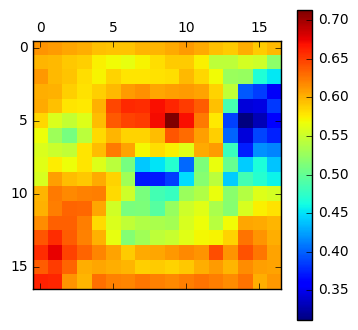

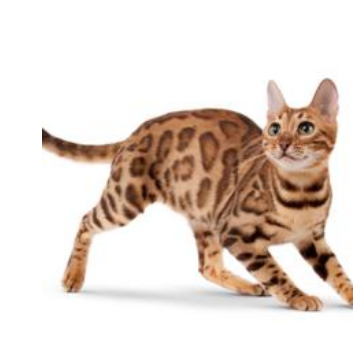

In [45]:
iters = floor((227-roi_size+1)/stride_size)
iters = iters.astype(int)
batch_size = iters**2
batch = np.ndarray([batch_size,227, 227, 3])
occlusion_map = np.ndarray([iters,iters])
occlusion_map2 = np.ndarray([iters,iters])
i = 0
for r in range(0,iters):
    for c in range(0,iters):
        occlusion_map[r,c] = res[i,0]
        i = i+1
print np.argmax(outbatch,1)
plt.matshow(occlusion_map)
colorbar()
plt.show()     

im = (imread("cat_10.jpg")[:,:,:3])
plt.axis("off")
plt.imshow(im)    
plt.show()                 